# Intial PyTorch FasterRCNN transfer learning object detection model

Adapted from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
# Import basics
import os
import numpy as np
import pandas as pd
import random
import time
import copy
from PIL import Image
import cv2
import requests
import zipfile
from pathlib import Path

# Import PyTorch
import torch

# Import torchvision 
import torchvision
from torchvision import datasets, models
#from torchvision.transforms import ToTensor
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader, ConcatDataset, WeightedRandomSampler

# Pytorch functional
import torchvision.transforms.functional as F

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!nvidia-smi

Mon Oct 17 16:14:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Clone pytorch vision into main directory to get utility helper functions

In [4]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 233363, done.
remote: Counting objects: 100% (7034/7034), done.
remote: Compressing objects: 100% (644/644), done.
remote: Total 233363 (delta 6530), reused 6812 (delta 6378), pack-reused 226329
Receiving objects: 100% (233363/233363), 469.60 MiB | 14.71 MiB/s, done.
Resolving deltas: 100% (211600/211600), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Batch hyperparameters

In [6]:
# random state
random_state = 42

# dataloading
batch_size = 16
num_workers = 2

## PyTorch data setup

### Load in data

### Import bounding box data

In [7]:
# specify paths
train_annotations = '/content/drive/MyDrive/Fourthbrain/Capstone/Image patch data/512px/v1_random_patches/train_annotations.csv'
test_annotations = '/content/drive/MyDrive/Fourthbrain/Capstone/Image patch data/512px/v1_random_patches/test_annotations.csv'

# load csvs
train_lbbox = pd.read_csv(train_annotations, index_col=0)
test_lbbox = pd.read_csv(test_annotations, index_col=0)

### Import 512 px image patches

In [8]:
data_path = Path("data/")
file_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Image patch data/512px/v1_random_patches/CODAEL_OD_1.zip' # file path to .zip file in your Google Drive

# Unzip image patch data
with zipfile.ZipFile(file_path, "r") as zip_ref:
    print("Unzipping data")
    zip_ref.extractall(data_path)

Unzipping data


Check image directory and annotations file match

In [10]:
# path to image directory
image_dir = '/content/data/CODAEL_OD_1'

# list of images in train and test folders
train_img = list(sorted(os.listdir(os.path.join(image_dir, 'train', 'Mitosis'))))
test_img = list(sorted(os.listdir(os.path.join(image_dir, 'test', 'Mitosis'))))

assert train_lbbox.shape[0] == len(train_img)
assert test_lbbox.shape[0] == len(test_img)

### Define custom PyTorch dataset class

In [11]:
class CODAEL_1_Dataset(torch.utils.data.Dataset):
  def __init__(self, annotations_file, image_dir, transforms, mode='train'):
    # import annotations file with bounding boxes, image ids, and labels
    self.img_labels = pd.read_csv(annotations_file, index_col=0)
    self.image_dir = image_dir
    self.transforms = transforms
    self.mode = mode
    # load images and sort them (keep in mind sorting strings)
    self.imgs = list(sorted(os.listdir(os.path.join(image_dir, mode, 'Mitosis'))))

  def __getitem__(self, idx):
    # load images
    img_path = os.path.join(self.image_dir, self.mode, 'Mitosis', self.imgs[idx])
    img = Image.open(img_path)

    # image id
    image_id = self.img_labels['image_id'].iloc[idx]
    image_id = torch.as_tensor(image_id, dtype=torch.int64)

    # bounding box coordinates (hard code bounding boxes for now)
    boxes = np.zeros(4)
    boxes = self.img_labels[['xmin','ymin','xmax','ymax']].iloc[idx]
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    boxes = torch.reshape(boxes, (1,4))

    # class label (all ones)
    #labels = self.img_labels['labels'].iloc[idx]
    #labels = torch.as_tensor(labels, dtype=torch.int64)
    labels = torch.ones((1,), dtype=torch.int64)

    # area of bounding box (all are 50 by 50 px = 2500 px^2), need this to make COCO utils happy.
    area = torch.as_tensor(50*50).reshape(1)

    # iscrowd: instances with iscrowd=True will be ignored during evaluation, need this to make COCO utils happy.
    # turn off
    iscrowd = torch.zeros((1,), dtype=torch.int64)

    # target dictionary
    target = {}
    target['boxes'] = boxes
    target['image_id'] = image_id
    target['labels'] = labels
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)
    
    return img, target

  def __len__(self):
    return len(self.imgs)


## Define function for PyTorch transforms

No augmentations for now

In [12]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    #if train:
        #transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Calculated mean and std for CODAEL_OD_1 dataset

CODAEL_OD_1 v1 dataset
* mean = [0.7441, 0.5223, 0.6265]
* std = [0.1409, 0.1618, 0.1320]

In [13]:
mean = [0.7441, 0.5223, 0.6265]
std = [0.1409, 0.1618, 0.1320]

* Load in train data from directory and randomly split (80/20) the train folder into training and validation sets
* Load in test data from directory separately

In [14]:
train_data = CODAEL_1_Dataset(annotations_file=train_annotations, 
                                image_dir=image_dir, 
                                  transforms=get_transform(train=True), 
                                    mode='train')
test_data = CODAEL_1_Dataset(annotations_file=test_annotations, 
                              image_dir=image_dir, 
                                transforms=get_transform(train=False), 
                                  mode='test')

### ONLY RUN FOR TESTING/DEBUGGING MODEL: Subset to small datasets/loaders for testing (50 examples)

In [15]:
subset = list(np.random.randint(0,len(train_data),50))
train_data = torch.utils.data.Subset(train_data, subset)

### Split into 80/20 train/validation splits

In [16]:
train_split = 0.8
training_examples = int(len(train_data)*train_split)
val_examples = len(train_data) - training_examples
train, val = torch.utils.data.random_split((train_data), 
                                            [training_examples, val_examples], 
                                                generator=torch.Generator().manual_seed(random_state))

### Visualize training images with ground truth bounding boxes

In [17]:
def visualize_train_data(train_dataset, num_examples, random_state=False):
  # if random state is true, then set seed to look at same images
  if random_state:
    np.random.seed(69)
 
  # set up subplots
  plt.figure(figsize=(24,18))
  plt.suptitle('Examples of mitotic figures on WSIs', fontsize=18)
  # random array of indices from train dataset
  array = np.random.randint(0, len(train), num_examples)
  # set number of rows based on desired number of columns
  cols = 3
  rows = int(np.ceil(num_examples/cols))
  # plot subplots
  for n, idx in enumerate(array):
    # add new subplot
    ax = plt.subplot(rows, cols, n + 1)
    
    # get image tensor and covert to integers
    img = (train[idx][0]*255).type(torch.uint8)

    # get bounding box and reshape
    box = train[idx][1]['boxes']
    box = torch.reshape(box, (1,4))

    # draw bounding box on image
    boxes = draw_bounding_boxes(img, box,
                                  colors='cyan', 
                                    width=3)
    im = F.to_pil_image(boxes.detach())
    ax.imshow(im)
  return


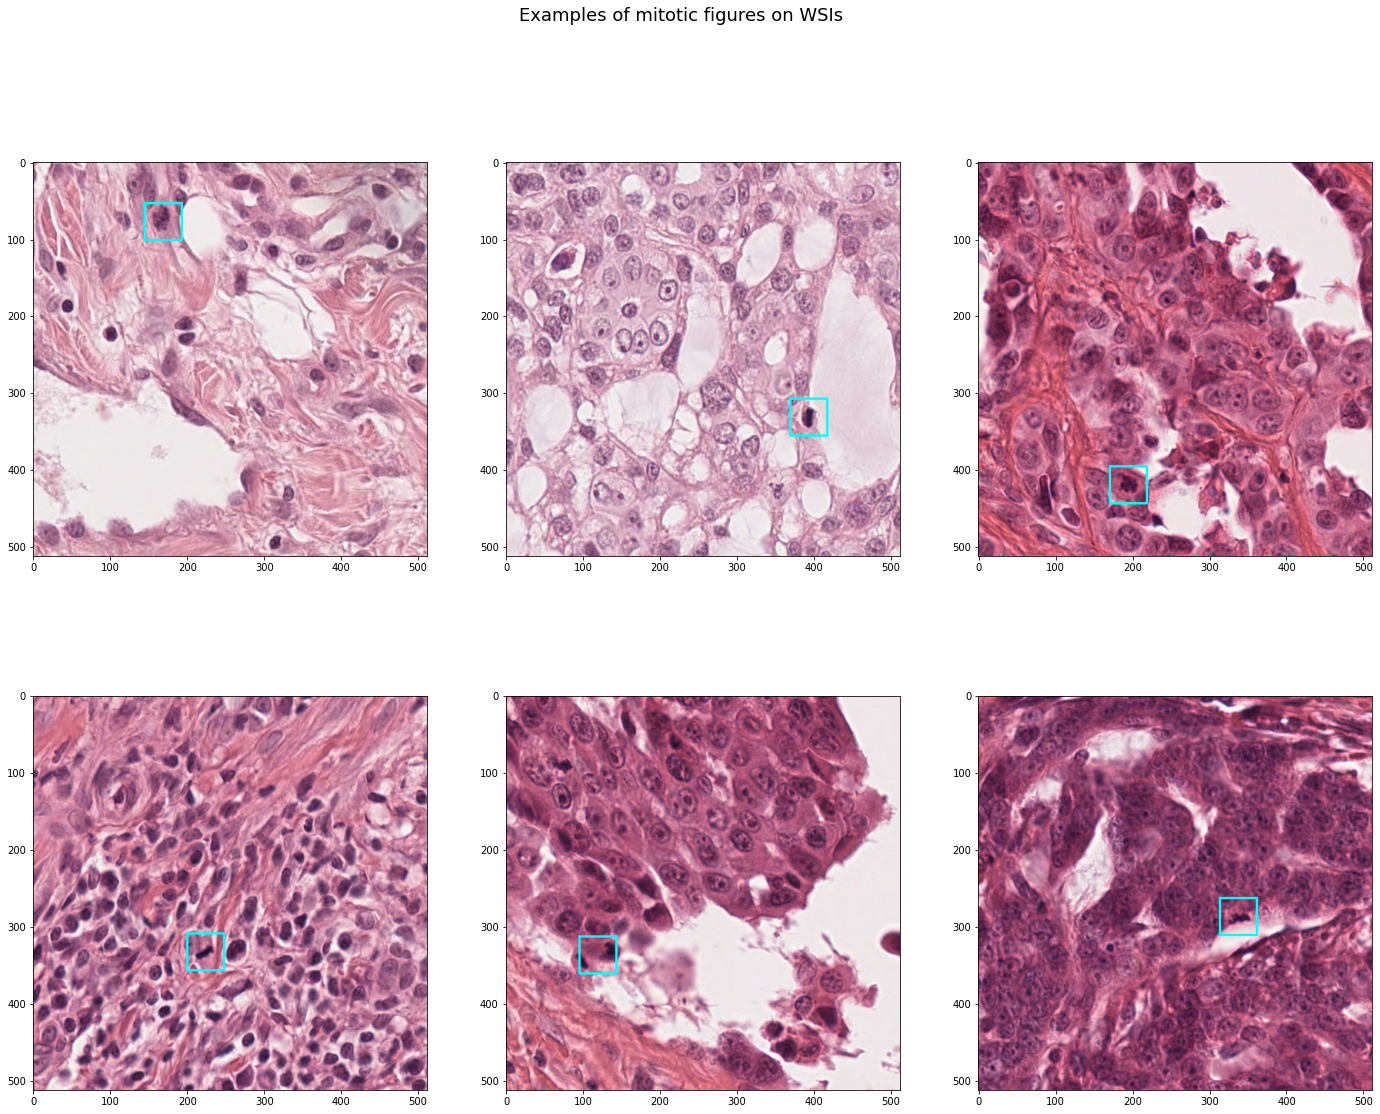

In [18]:
visualize_train_data(train, 6, random_state=False)

## Create PyTorch dataloaders

Create dictionary of train, validation, and test sets. specify shuffle for each dataset.

In [19]:
image_datasets = {'train': [train, True],
                    'val': [val, True],
                        'test': [test_data, False]} # usually don't shuffle test data

dataset_sizes = {x: len(image_datasets[x][0]) for x in ['train','val','test']}
print(dataset_sizes)

{'train': 40, 'val': 10, 'test': 3412}


### Create dataloaders

In [20]:
import utils

dataloaders = {x: DataLoader(image_datasets[x][0], 
                                batch_size=batch_size, 
                                    num_workers=num_workers, 
                                        shuffle=image_datasets[x][1],
                                          collate_fn=utils.collate_fn)
                for x in ['train','val','test']}
dataloader_sizes = {x: len(dataloaders[x]) for x in ['train','val','test']}
print(dataloader_sizes)

{'train': 3, 'val': 1, 'test': 214}


# Set up model

### Create function to call Faster RCNN model

In [21]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_od(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

  # replace the classifier with a new one, that has
  # num_classes which is user-defined
  num_classes = 2  # 1 class (person) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

### Instantiate model

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# instantiate the model using our helper function
model = get_model_od(num_classes=2)

# move model to the right device
model.to(device)

### Model hyperparameters

In [23]:
# Learning
num_epochs = 2
lr = 0.005
momentum = 0.9
weight_decay = 0.005
step_size = 3
gamma = 0.1

## Set optimizer and learning rate scheduler

In [24]:
# construct optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,
                            momentum=momentum, weight_decay=weight_decay)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=step_size,
                                                gamma=gamma)

## Main training function

In [28]:
from engine import train_one_epoch, evaluate
import utils

def main(dataloaders, model, optimizer, lr_scheduler, num_epochs):

    # get the training and validation data loaders
    data_loader = dataloaders['train']
    data_loader_test = dataloaders['val']

    for epoch in range(num_epochs):
        # train for one epoch, printing every 20 batches
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

## Train the model

In [ ]:
main(dataloaders, model, optimizer, lr_scheduler, num_epochs)

## Save model

**Warning:** make sure to set model name. If statement will add 'next' to model name if it already exists in the specified path

In [36]:
path = '/content/drive/MyDrive/Fourthbrain/Capstone/models/Object Detection/CODAEL_1'
model_name = 'CODAEL_OD_v1_run_0'

In [45]:
if model_name+'.pth' in os.listdir(path):
  model_name = model_name+'_next'

torch.save(model, os.path.join(path, model_name + '.pth'))
torch.save(model.state_dict(), os.path.join(path, model_name + '_weights.pth'))

# Evaluate model

Define whether to load a model or use the one just trained

In [141]:
load_model = True
path = '/content/drive/MyDrive/Fourthbrain/Capstone/models/Object Detection/CODAEL_1'
model_name = 'CODAEL_OD_v0_run_0'

In [142]:
if load_model:
  # get current device
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  # re-instantiate model w/helper function and load state_dict into model
  model = get_model_od(num_classes=2)
  model.load_state_dict(torch.load(os.path.join(path, model_name+'_weights.pth')))
  # write model to device
  model.to(device)
else:
  model.to(device)

## Evaluate model on the entire test set

**Warning:** Takes awhile to run. Get predicted bounding boxes and scores from test dataloader as well as ground truth bounding boxes and image tensors for plotting later

In [330]:
def evaluate_model(model, data_loader):
  torch.manual_seed(random_state)
  predictions = []
  labels = []
  batch=0
  total_batches = len(data_loader)
  model.eval()
  with torch.inference_mode(): # can also use torch.no_grad()
    for images, targets in data_loader:
      for idx, img in enumerate(images):
        # make prediction on single image
        output = model([img.to(device)])
        # get target data (ground truth bounding boxes, image_id, etc.)
        target = targets[idx]
        # append lists
        predictions.append(output)
        labels.append(target)
      batch +=1
      if batch%25 == 0:
        print('Done with batch {} out of {}'.format(batch, total_batches))
  return predictions, labels

In [306]:
%%time
predictions, labels = evaluate_model(model, dataloaders['test'])

Done with batch 25 out of 214
Done with batch 50 out of 214
Done with batch 75 out of 214
Done with batch 100 out of 214
Done with batch 125 out of 214
Done with batch 150 out of 214
Done with batch 175 out of 214
Done with batch 200 out of 214
CPU times: user 4min 54s, sys: 5.55 s, total: 4min 59s
Wall time: 5min 5s


### Get lists of predictions and labels

Function to generate dictionary of lists of predicted bounding boxes, ground truth bounding boxes, and scores. Filters out test images that had no predicted bounding box.

In [307]:
def get_prediction_lists(predictions, labels):
  predicted_bbs = []
  predicted_bbs_scores = []
  gt_bbs = []
  ids = []
  num_examples = len(predictions)

  for idx, img in enumerate(predictions):
    if len(img[0]['boxes']) == 0: # filter out images that had no predicted bounding boxes
      continue
    # get predicted bounding boxes
    bbs = img[0]['boxes']
    # get predicted bounding box scores
    scores = img[0]['scores']
    # get ground truth label of test set
    gt = labels[idx]['boxes']
    # get image id of test set
    id = labels[idx]['image_id']

    # append lists
    predicted_bbs.append(bbs)
    predicted_bbs_scores.append(scores)
    gt_bbs.append(gt)
    ids.append(id)

    # create dictionary
    lists = {'predicted_bbs': predicted_bbs,
              'predicted_bbs_scores': predicted_bbs_scores,
                'gt_bbs': gt_bbs,
                  'image_ids': ids}


  print('Number of test images with no predicted bounding boxes: {} out of {}'.format((num_examples - len(predicted_bbs)), num_examples))
  return lists

In [308]:
lists = get_prediction_lists(predictions, labels)

Number of test images with no predicted bounding boxes: 11 out of 3412


### Intersection over union (IoU) calculation

Intersection over union function

In [309]:
def bounding_box_iou(boxA:list, boxB:list) -> float:
    """
    Computes the Intersection over Union for two bounding boxes

    Args:
        boxA (ymin, xmin, ymax, xmax)
        boxB (ymin, xmin, ymax, xmax)
    
    Return: intersection Over Union metric given two boxes cordinates
    """
    # YOUR CODE HERE
    # coordinates of intersection
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[0], boxB[0])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[2], boxB[2])

    # intersection area
    intersection = max(0, xB - xA)*max(0, yB - yA)

    # bounding box areas
    boxA_area = (boxA[3] - boxA[1])*(boxA[2] - boxA[0])
    boxB_area = (boxB[3] - boxB[1])*(boxB[2] - boxB[0])

    # union
    union = boxA_area + boxB_area - intersection

    # IOU
    iou = float(intersection/union)

    return iou

### Get average IoU and score for the test set

In [311]:
def compute_best_iou_and_score(gt_bounding_box, predicted_bounding_boxes, prediction_scores_per_bb):
    """
    compute the best IoU and scores
    gt_bounding box: list of ground truth bounding boxes of test images
    predicted_bounding_boxes: list len(# of test images) of the 100 predicted bounding boxes
    prediction_score_per_bb: list len(# of test images) of the 100 predicted bounding box scores
    """
    # lists to keep track of iou and score of the best bounding box for each test image
    test_ious = []
    scores = []

    # outer loop to step through test images (n=40)
    for bbox_idx in range(len(predicted_bounding_boxes)):
      # reset list to keep track of ious of current test image (bbox_idx)
      ious = []

      # inner loop to step through the 100 predicted bounding boxes and scores
      for pred_idx in range(len(predicted_bounding_boxes[bbox_idx])):
        iou = bounding_box_iou(gt_bounding_box[bbox_idx][0], predicted_bounding_boxes[bbox_idx][pred_idx])
        ious.append(iou)
      if len(ious) == 0:
        return 0, 0
      
      # get index of best bounding box
      best_bounding_box = np.argmax(ious)

      # log best iou and score for the current test image
      test_ious.append(ious[best_bounding_box])
      scores.append(prediction_scores_per_bb[bbox_idx][best_bounding_box].item())

    return test_ious, scores

In [312]:
gt_bounding_box = lists['gt_bbs']
predicted_bounding_boxes = lists['predicted_bbs']
prediction_scores_per_bb = lists['predicted_bbs_scores']

ious, scores = compute_best_iou_and_score(gt_bounding_box, predicted_bounding_boxes, prediction_scores_per_bb)

print('The mean IoU on the test images is: ', np.mean(ious))
print('The associated scores are: ', np.mean(scores))

The mean IoU on the test images is:  0.8620209248051358
The associated scores are:  0.8939999748953509


## Make predictions on a smaller batch of images from test set and visualize

Print out average IoU and scores then visualize the predictions of a specified number of test set examples

In [399]:
torch.manual_seed(random_state)
def visualize_predictions(dataset, num_examples, random_state=False):
  # if random state is true, then set seed to look at same images
  if random_state:
    np.random.seed(69)

  predictions = []
  labels = []

  array = np.random.randint(0, len(dataset), num_examples)

  model.eval()
  with torch.inference_mode(): # can also use torch.no_grad()
    for idx in array:
      # make prediction on single image
      image = dataset[idx][0]
      output = model([image.to(device)])
      # get target data (ground truth bounding boxes, image_id, etc.)
      target = dataset[idx][1]
      # append lists
      predictions.append(output)
      labels.append(target)

  # call get prediction lists function (filters out images with no predicted bbox)
  lists = get_prediction_lists(predictions, labels)

  # call iou and scores calculator
  gt_bounding_box = lists['gt_bbs']
  predicted_bounding_boxes = lists['predicted_bbs']
  prediction_scores_per_bb = lists['predicted_bbs_scores']

  ious, scores = compute_best_iou_and_score(gt_bounding_box, predicted_bounding_boxes, prediction_scores_per_bb)

  print('The mean IoU on the test images is: ', np.mean(ious))
  print('The associated scores are: ', np.mean(scores))

  # Plots
  # set up subplots
  plt.figure(figsize=(24,18))
  plt.suptitle('Predicted (black) and ground truth (cyan) bounding boxes of mitotic figures on WSIs', fontsize=18)

  # set number of rows based on desired number of columns
  cols = 3
  rows = int(np.ceil(num_examples/cols))
  # plot subplots
  for n, idx in enumerate(array):
    # add new subplot
    ax = plt.subplot(rows, cols, n + 1)
    
    # get image tensor and covert to integers
    img = (dataset[idx][0]*255).type(torch.uint8)

    # get best predicted bounding box and reshape
    box1 = predicted_bounding_boxes[n][0]
    box1 = torch.reshape(box1, (1,4))

    # get ground truth bounding box and reshape (need to write to device)
    box2 = gt_bounding_box[n].to(device)
    box2 = torch.reshape(box2, (1,4))

    # concatenate predicted and ground truth bboxes
    box = torch.cat((box1, box2), 0)

    # draw bounding box on image
    boxes = draw_bounding_boxes(img, box,
                                  colors=['black','cyan'],
                                    labels=['predicted','gt'],
                                      width=3)
    im = F.to_pil_image(boxes.detach())
    ax.imshow(im)
  return

Number of test images with no predicted bounding boxes: 0 out of 8
The mean IoU on the test images is:  0.8455030843615532
The associated scores are:  0.9385074749588966


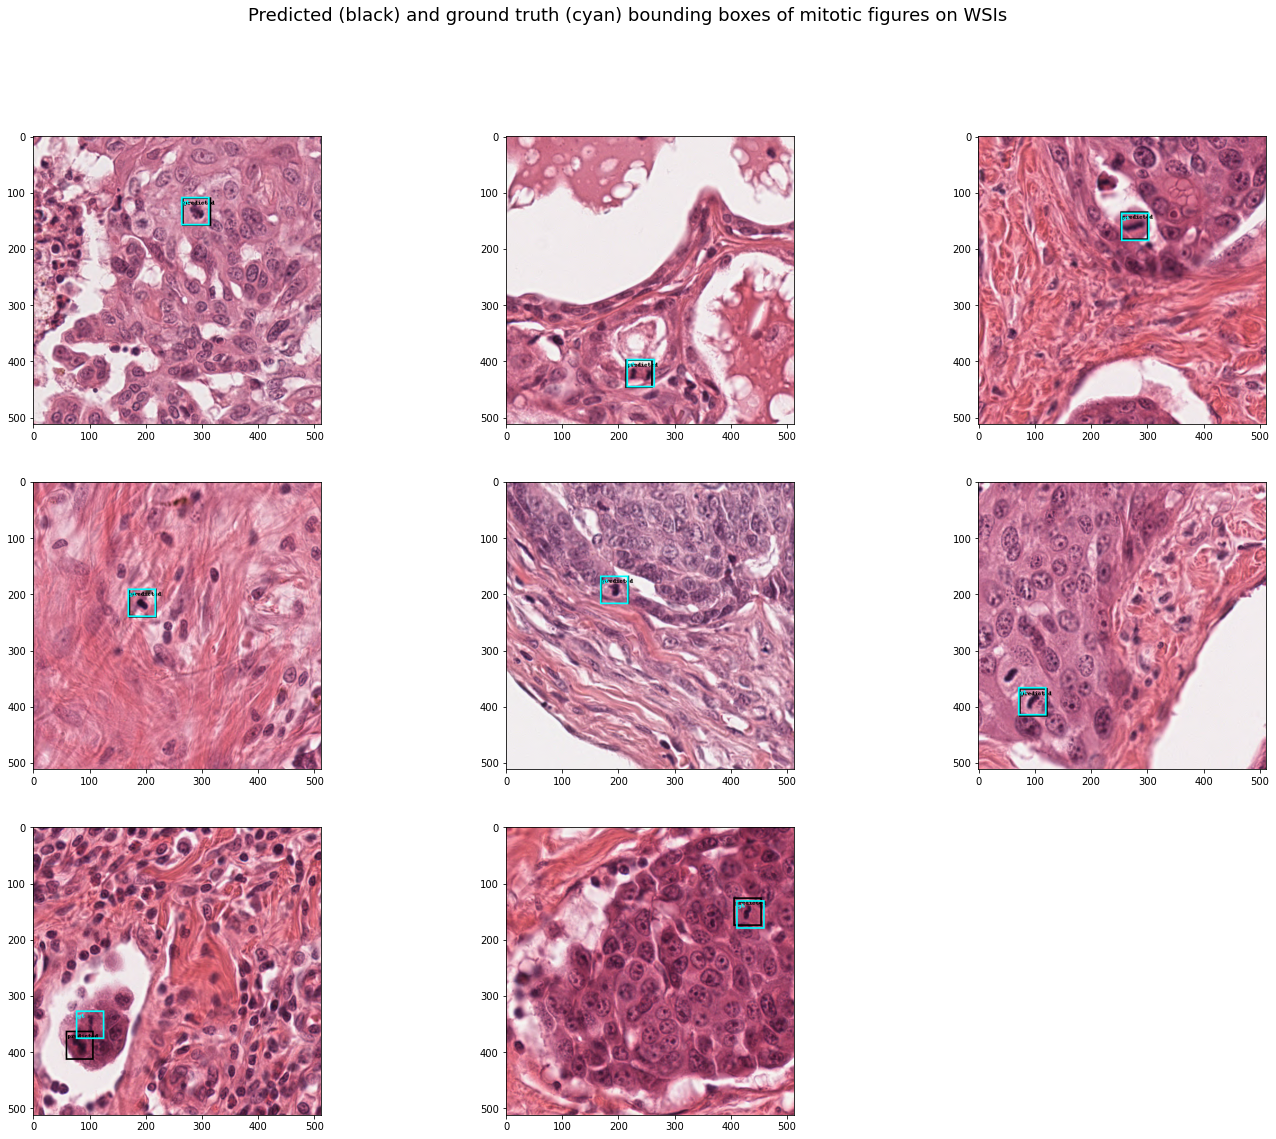

In [401]:
visualize_predictions(test_data, 8, random_state=False)